In [1]:
# Complete imports and matplotlib setup
import matplotlib
matplotlib.use('Agg')  # Use non-interactive backend first
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import cv2
import os
import sys

# Set up matplotlib for static plots (no JavaScript dependencies)
%matplotlib inline

print("All imports loaded successfully")
print("Matplotlib backend:", matplotlib.get_backend())

All imports loaded successfully
Matplotlib backend: inline


In [2]:
def set_up_cameras():
    """CORRECTED camera setup - cameras look in +Y direction (forward)."""
    print("\n=== CORRECTED CAMERA SETUP (+Y LOOKING) ===", flush=True)
    
    # Camera intrinsic matrices (same for both cameras)
    K = np.array([
        [1000, 0, 640],
        [0, 1000, 360], 
        [0, 0, 1]
    ], dtype=np.float64)
    
    # CORRECTED camera positions (Z=2.55 avoids singularities at trajectory Z=2.5)
    cam1_center = np.array([0.0, 0.0, 2.55])  # Camera 1 at origin, raised in Z
    cam2_center = np.array([1.0, 0.0, 2.55])  # Camera 2 translated along X axis, raised in Z
    
    # CORRECTED rotation matrices for +Y looking cameras
    # Standard OpenCV: Identity rotation = cameras look in -Z direction
    # Our correction: Rotate 90° around X-axis to make cameras look in +Y direction
    R_corrected = np.array([
        [1,  0,  0],   # X axis unchanged
        [0,  0, -1],   # Y axis becomes -Z (depth in camera coordinates)
        [0,  1,  0]    # Z axis becomes Y (vertical in camera coordinates)
    ], dtype=np.float64)
    
    R1 = R_corrected.copy()
    R2 = R_corrected.copy()
    
    # Translation vectors for projection matrices
    # t = -R * C where C is the camera center in world coordinates
    t1 = -np.dot(R1, cam1_center.reshape(3, 1))
    t2 = -np.dot(R2, cam2_center.reshape(3, 1))
    
    print(f"Camera 1 world position: {cam1_center}")
    print(f"Camera 2 world position: {cam2_center}")
    print(f"Baseline: {np.linalg.norm(cam2_center - cam1_center):.3f} meters")
    print(f"✅ Both cameras look in +Y direction (forward)")
    print(f"Rotation matrix (both cameras):")
    print(R1)
    
    # Projection matrices P = K[R|t]
    P1 = np.dot(K, np.hstack((R1, t1)))
    P2 = np.dot(K, np.hstack((R2, t2)))
    
    print(f"Camera 1 projection matrix shape: {P1.shape}")
    print(f"Camera 2 projection matrix shape: {P2.shape}")
    
    return P1, P2, cam1_center, cam2_center

In [ ]:
# CORRECTED PROJECTION AND TRIANGULATION FUNCTIONS
# These replace the existing functions with the coordinate system fix

def project_point_corrected(P, point_3d):
    """Project 3D world point to 2D image coordinates - CORRECTED version."""
    # Convert to homogeneous coordinates
    point_3d_h = np.append(point_3d, 1.0)
    
    # Project: pixel_h = P * point_3d_h
    proj = np.dot(P, point_3d_h)
    
    # Handle points at camera plane (avoid division by zero)
    if abs(proj[2]) < 1e-10:
        return np.array([float('inf'), float('inf')])
    
    # Convert from homogeneous to Cartesian coordinates
    return proj[:2] / proj[2]

def triangulate_point_corrected(pixel1, pixel2, P1, P2):
    """Triangulate 3D point from stereo 2D observations - CORRECTED version."""
    # Set up linear system: A * X = 0
    # where X is the homogeneous 3D point [x, y, z, 1]
    A = np.array([
        pixel1[0] * P1[2, :] - P1[0, :],  # u1*P1[2,:] - P1[0,:]
        pixel1[1] * P1[2, :] - P1[1, :],  # v1*P1[2,:] - P1[1,:]
        pixel2[0] * P2[2, :] - P2[0, :],  # u2*P2[2,:] - P2[0,:]
        pixel2[1] * P2[2, :] - P2[1, :]   # v2*P2[2,:] - P2[1,:]
    ])
    
    # Solve using SVD: A = U * S * V^T
    # Solution is last column of V (smallest singular value)
    _, _, Vt = np.linalg.svd(A)
    X_h = Vt[-1, :]
    
    # Convert from homogeneous to Cartesian coordinates
    return X_h[:3] / X_h[3]

print("✅ Corrected projection and triangulation functions loaded!")


In [3]:
def plot_camera_fov_on_plane(ax, camera_pos, color, fov_angle_deg=60, plane_y=1.0, max_distance=4.0):
    """Plot camera field of view intersection with y=plane_y plane.
    
    CORRECTED COORDINATE SYSTEM EXPLANATION:
    - Cameras at Y=0 look in +Y direction (forward)
    - Trajectory plane at Y=1.0 is PERPENDICULAR to optical axis
    - FOV intersection creates a RECTANGLE on the Y=1.0 plane
    - "Z distance" refers to height variations within the plane
    Modified for 3d_tracker_9: Default plane_y=1.0
    """
    
    # Camera intrinsic parameters - assuming square pixels and symmetric FOV
    fov_horizontal = np.radians(fov_angle_deg)  # Horizontal FOV
    fov_vertical = np.radians(fov_angle_deg * 0.75)  # Vertical FOV (4:3 aspect ratio)
    
    # Distance from camera to the y=1.0 plane (along optical axis)
    dy = abs(camera_pos[1] - plane_y)  # This is 1.0 meters forward from camera
    
    # For cameras looking in +Y direction, the FOV projection onto y=plane_y 
    # creates a RECTANGLE because the plane is PERPENDICULAR to the optical axis
    
    # Calculate rectangular FOV boundaries on the y=1.0 plane
    # Since the plane is PERPENDICULAR to the optical axis, FOV is a simple rectangle
    
    # At distance dy from camera, calculate FOV dimensions
    half_width_x = dy * np.tan(fov_horizontal / 2)  # Horizontal half-width
    half_height_z = dy * np.tan(fov_vertical / 2)   # Vertical half-height
    
    # Rectangle corners on the Y=1.0 plane
    x_min = camera_pos[0] - half_width_x
    x_max = camera_pos[0] + half_width_x
    z_min = camera_pos[2] - half_height_z
    z_max = camera_pos[2] + half_height_z
    
    # Draw the rectangular FOV outline
    rect_x = [x_min, x_max, x_max, x_min, x_min]
    rect_z = [z_min, z_min, z_max, z_max, z_min]
    rect_y = [plane_y] * 5
    
    ax.plot(rect_x, rect_y, rect_z, 
            color=color, linewidth=3, alpha=0.8, linestyle='-', 
            label=f'{color.title()} FOV Rectangle')
    
    # Add a note about the geometry
    mid_x = camera_pos[0]
    mid_z = camera_pos[2]
    ax.text(mid_x, plane_y + 0.1, mid_z, 
            f'{color.title()}\nRectangle\n(perpendicular plane)', 
            color=color, fontsize=8, ha='center', va='bottom')
    print(f"Added {color} camera FOV on y={plane_y} plane - creates rectangle due to perpendicular intersection")

def plot_rectangular_fov_reference(ax, camera_pos, color, fov_angle_deg=60, plane_y=1.0, distance=2.0):
    """Show what the FOV would look like as a rectangle if camera looked perpendicular to plane."""
    
    # Calculate what a rectangular FOV would look like if the camera 
    # were positioned to look perpendicular to the y=1.0 plane
    
    fov_rad = np.radians(fov_angle_deg)
    half_fov = fov_rad / 2
    
    # If camera looked directly at the plane from distance 'distance'
    # Position camera at (camera_pos[0], plane_y - distance, camera_pos[2])
    virtual_cam_y = plane_y - distance
    
    # Rectangle dimensions on the plane
    half_width = distance * np.tan(half_fov)
    half_height = half_width * 0.75  # Assuming 4:3 aspect ratio
    
    # Rectangle corners on the y=1.0 plane
    x_min = camera_pos[0] - half_width
    x_max = camera_pos[0] + half_width
    z_min = camera_pos[2] - half_height
    z_max = camera_pos[2] + half_height
    
    # Draw the rectangular FOV outline
    rect_x = [x_min, x_max, x_max, x_min, x_min]
    rect_z = [z_min, z_min, z_max, z_max, z_min]
    rect_y = [plane_y] * 5
    
    ax.plot(rect_x, rect_y, rect_z, 
            color=color, linewidth=2, alpha=0.5, linestyle=':', 
            label=f'{color.title()} Rectangular FOV (reference)')
    
    # Add text annotation
    ax.text(camera_pos[0], plane_y + 0.2, camera_pos[2], 
            f'{color.title()}\nRectangle\n(if perpendicular)', 
            color=color, fontsize=8, ha='center', va='bottom', alpha=0.7)


In [4]:
def plot_camera(ax, camera_pos, color, label, boresight_length=3.0):
    """Plot a camera in 3D space with frustum and boresight line of sight."""
    print(f"Plotting camera: {label} at position {camera_pos}")
    
    # Plot camera position with a large marker
    ax.scatter(camera_pos[0], camera_pos[1], camera_pos[2], 
              color=color, marker='*', s=1000, label=label,
              edgecolor='black', linewidth=2.0)
    
    # Add a vertical stem line from ground to camera
    ax.plot([camera_pos[0], camera_pos[0]], 
            [camera_pos[1], camera_pos[1]], 
            [0, camera_pos[2]], 
            color=color, linewidth=4.0, alpha=0.7)
    
    # Add text label with coordinates
    ax.text(camera_pos[0], camera_pos[1], camera_pos[2] + 0.3,
            f"{label}\n({camera_pos[0]:.1f}, {camera_pos[1]:.1f}, {camera_pos[2]:.1f})",
            color=color, fontsize=10, weight='bold', ha='center')
    
    # Define boresight direction (looking forward and down at 45 degrees)
    elevation_angle = -45  # degrees
    azimuth_angle = 0  # degrees
    
    # Convert angles to direction vector
    elevation_rad = np.radians(elevation_angle)
    azimuth_rad = np.radians(azimuth_angle)
    
    boresight_dir = np.array([
        np.cos(elevation_rad) * np.sin(azimuth_rad),
        np.cos(elevation_rad) * np.cos(azimuth_rad),
        np.sin(elevation_rad)
    ])
    
    # Normalize the direction vector
    boresight_dir = boresight_dir / np.linalg.norm(boresight_dir)
    
    # Calculate boresight end point
    boresight_end = camera_pos + boresight_dir * boresight_length
    
    # Draw boresight line of sight
    ax.plot([camera_pos[0], boresight_end[0]],
            [camera_pos[1], boresight_end[1]],
            [camera_pos[2], boresight_end[2]],
            color=color, linewidth=2.0, linestyle='--',
            alpha=0.7)
    
    print(f"Camera {label} plotted successfully")

In [5]:
def generate_synthetic_tracks():
    """Generate synthetic 3D track and project to 2D camera views - CORRECTED version.
    Modified for 3d_tracker_9: ALL POINTS LIE IN THE PLANE Y = 1.0"""
    # Get CORRECTED camera matrices
    P1, P2, _, _ = set_up_cameras()
    
    print("\n=== GENERATING SYNTHETIC TRACKS (CORRECTED) - Y=1.0 PLANE ===", flush=True)
    
    # Define a 3D trajectory (moving object) - ALL POINTS IN Y=1.0 PLANE
    # With CORRECTED cameras at Z=2.55, this trajectory will work perfectly
    original_3d = [
        np.array([0.1, 1.0, 2.3]),   # Start: left, Y=1.0, low
        np.array([0.2, 1.0, 2.4]),   # Moving right, Y=1.0, up
        np.array([0.3, 1.0, 2.5]),   # Continuing motion, Y=1.0
        np.array([0.4, 1.0, 2.6]),   # Peak height, Y=1.0
        np.array([0.5, 1.0, 2.5]),   # Descending, Y=1.0
        np.array([0.6, 1.0, 2.4]),   # Continuing right, Y=1.0
        np.array([0.7, 1.0, 2.3]),   # End: right, Y=1.0, low
    ]
    
    sensor1_track = []
    sensor2_track = []
    
    for i, point_3d in enumerate(original_3d):
        print(f"Processing point {i+1}: {point_3d}")
        
        # Use CORRECTED projection function
        pixel1 = project_point_corrected(P1, point_3d)
        pixel2 = project_point_corrected(P2, point_3d)
        
        sensor1_track.append(pixel1)
        sensor2_track.append(pixel2)
        
        # Check if projections are finite
        finite1 = np.isfinite(pixel1).all()
        finite2 = np.isfinite(pixel2).all()
        
        print(f"  Camera 1 pixel: [{pixel1[0]:.1f}, {pixel1[1]:.1f}] (finite: {finite1})")
        print(f"  Camera 2 pixel: [{pixel2[0]:.1f}, {pixel2[1]:.1f}] (finite: {finite2})")
        
        if not (finite1 and finite2):
            print(f"  ⚠️ Point {i+1} has infinite projections!")
        else:
            print(f"  ✅ Point {i+1} projects successfully!")
    
    # Convert to numpy arrays
    sensor1_track = np.array(sensor1_track)
    sensor2_track = np.array(sensor2_track)
    original_3d = np.array(original_3d)
    
    print(f"\nGenerated tracks:")
    print(f"Sensor 1 track shape: {sensor1_track.shape}")
    print(f"Sensor 2 track shape: {sensor2_track.shape}")
    print(f"Original 3D shape: {original_3d.shape}")
    
    # Summary of finite projections
    finite_count = sum(1 for i in range(len(sensor1_track)) 
                      if np.isfinite(sensor1_track[i]).all() and np.isfinite(sensor2_track[i]).all())
    print(f"✅ {finite_count}/{len(original_3d)} points have finite projections")
    
    return sensor1_track, sensor2_track, original_3d

In [6]:
def triangulate_tracks(sensor1_track, sensor2_track, P1, P2):
    """Triangulate 3D points from 2D tracks from two cameras - CORRECTED version."""
    points_3d = []
    
    for i, (pt1, pt2) in enumerate(zip(sensor1_track, sensor2_track)):
        # Skip invalid points
        if not (np.isfinite(pt1[0]) and np.isfinite(pt1[1]) and 
                np.isfinite(pt2[0]) and np.isfinite(pt2[1])):
            print(f"Skipping invalid points at frame {i+1}: {pt1}, {pt2}")
            points_3d.append(np.array([np.nan, np.nan, np.nan]))
            continue
            
        # Use CORRECTED triangulation function
        try:
            point_3d = triangulate_point_corrected(pt1, pt2, P1, P2)
            
            # Validate the result
            if np.isfinite(point_3d).all():
                points_3d.append(point_3d)
                print(f"✅ Frame {i+1}: Triangulated {point_3d}")
            else:
                print(f"⚠️ Frame {i+1}: Invalid triangulation result")
                points_3d.append(np.array([np.nan, np.nan, np.nan]))
                
        except Exception as e:
            print(f"❌ Frame {i+1}: Triangulation error: {e}")
            points_3d.append(np.array([np.nan, np.nan, np.nan]))
    
    return np.array(points_3d)

In [7]:
def plot_2d_camera_views(sensor1_track, sensor2_track, original_3d):
    """Plot separate 2D views showing the trajectory as seen by each camera."""
    print("\n=== CREATING 2D CAMERA VIEWS ===", flush=True)
    
    # Create figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Camera 1 view (left plot)
    ax1.set_title('Camera 1 View\n(Object Trajectory in Image Plane)', fontsize=14, weight='bold')
    ax1.set_xlabel('X (pixels)', fontsize=12)
    ax1.set_ylabel('Y (pixels)', fontsize=12)
    
    # Plot the trajectory points
    for i, (pixel, point_3d) in enumerate(zip(sensor1_track, original_3d)):
        ax1.scatter(pixel[0], pixel[1], s=200, c='red', alpha=0.7, 
                   edgecolor='black', linewidth=2, zorder=5)
        ax1.annotate(f'P{i+1}\n3D:({point_3d[0]:.1f},{point_3d[1]:.1f},{point_3d[2]:.1f})', 
                    (pixel[0], pixel[1]), xytext=(10, 10), textcoords='offset points',
                    fontsize=10, ha='left', va='bottom',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    # Connect the points to show trajectory
    ax1.plot([p[0] for p in sensor1_track], [p[1] for p in sensor1_track], 
             'r-', linewidth=3, alpha=0.6, label='Trajectory')
    
    # Add directional arrows
    for i in range(len(sensor1_track)-1):
        dx = sensor1_track[i+1][0] - sensor1_track[i][0]
        dy = sensor1_track[i+1][1] - sensor1_track[i][1]
        ax1.arrow(sensor1_track[i][0], sensor1_track[i][1], 
                 dx*0.7, dy*0.7, head_width=15, head_length=10, 
                 fc='darkred', ec='darkred', alpha=0.8)
    
    # Set camera 1 image bounds (assuming 1280x720 image)
    ax1.set_xlim(0, 1280)
    ax1.set_ylim(720, 0)  # Invert Y axis (image coordinates)
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper right')
    
    # Camera 2 view (right plot)
    ax2.set_title('Camera 2 View\n(Object Trajectory in Image Plane)', fontsize=14, weight='bold')
    ax2.set_xlabel('X (pixels)', fontsize=12)
    ax2.set_ylabel('Y (pixels)', fontsize=12)
    
    # Plot the trajectory points
    for i, (pixel, point_3d) in enumerate(zip(sensor2_track, original_3d)):
        ax2.scatter(pixel[0], pixel[1], s=200, c='blue', alpha=0.7, 
                   edgecolor='black', linewidth=2, zorder=5)
        ax2.annotate(f'P{i+1}\n3D:({point_3d[0]:.1f},{point_3d[1]:.1f},{point_3d[2]:.1f})', 
                    (pixel[0], pixel[1]), xytext=(10, 10), textcoords='offset points',
                    fontsize=10, ha='left', va='bottom',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    # Connect the points to show trajectory
    ax2.plot([p[0] for p in sensor2_track], [p[1] for p in sensor2_track], 
             'b-', linewidth=3, alpha=0.6, label='Trajectory')
    
    # Add directional arrows
    for i in range(len(sensor2_track)-1):
        dx = sensor2_track[i+1][0] - sensor2_track[i][0]
        dy = sensor2_track[i+1][1] - sensor2_track[i][1]
        ax2.arrow(sensor2_track[i][0], sensor2_track[i][1], 
                 dx*0.7, dy*0.7, head_width=15, head_length=10, 
                 fc='darkblue', ec='darkblue', alpha=0.8)
    
    # Set camera 2 image bounds
    ax2.set_xlim(0, 1280)
    ax2.set_ylim(720, 0)  # Invert Y axis (image coordinates)
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='upper right')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()
    
    # Print trajectory information
    print("\nCamera 1 Trajectory (pixels):")
    for i, (pixel, point_3d) in enumerate(zip(sensor1_track, original_3d)):
        print(f"  Point {i+1}: ({pixel[0]:.1f}, {pixel[1]:.1f}) <- 3D: ({point_3d[0]:.1f}, {point_3d[1]:.1f}, {point_3d[2]:.1f})")
    
    print("\nCamera 2 Trajectory (pixels):")
    for i, (pixel, point_3d) in enumerate(zip(sensor2_track, original_3d)):
        print(f"  Point {i+1}: ({pixel[0]:.1f}, {pixel[1]:.1f}) <- 3D: ({point_3d[0]:.1f}, {point_3d[1]:.1f}, {point_3d[2]:.1f})")
    
    print("\n2D camera views complete!")


In [8]:
# Test all functions
print("Testing camera setup...")
P1, P2, cam1_pos, cam2_pos = set_up_cameras()

print("\nTesting track generation...")
sensor1_track, sensor2_track, original_3d = generate_synthetic_tracks()

print("\nTesting triangulation...")
reconstructed_3d = triangulate_tracks(sensor1_track, sensor2_track, P1, P2)

print("\n=== ALL FUNCTIONS READY ===")
print("You can now run the visualization cells!")

# Verify the geometric correction worked
print("\n=== GEOMETRIC VERIFICATION ===")
print("3D Trajectory X coordinates:", [pt[0] for pt in original_3d])
print("Camera 1 pixel X coordinates:", [pt[0] for pt in sensor1_track])
print("Camera 2 pixel X coordinates:", [pt[0] for pt in sensor2_track])
print("\nExpected behavior:")
print("- Camera 1 (at X=0): Object moves RIGHT → pixels should INCREASE")
print("- Camera 2 (at X=1): Object moves LEFT relative to camera → pixels should DECREASE")

Testing camera setup...

=== SETTING UP CAMERAS ===
Camera 1 world position: [0.  0.  2.5]
Camera 2 world position: [1.  0.  2.5]
Camera 1 translation vector: [-0.  -0.  -2.5]
Camera 2 translation vector: [-1.  -0.  -2.5]
Camera 1 projection matrix shape: (3, 4)
Camera 2 projection matrix shape: (3, 4)

Testing track generation...

=== SETTING UP CAMERAS ===
Camera 1 world position: [0.  0.  2.5]
Camera 2 world position: [1.  0.  2.5]
Camera 1 translation vector: [-0.  -0.  -2.5]
Camera 2 translation vector: [-1.  -0.  -2.5]
Camera 1 projection matrix shape: (3, 4)
Camera 2 projection matrix shape: (3, 4)

=== GENERATING SYNTHETIC TRACKS ===
Processing point 0: [0.2 1.  2.7]
  Camera 1 pixel: [1640. 5360.]
  Camera 2 pixel: [-3360.  5360.]
Processing point 1: [0.3 1.  2.6]
  Camera 1 pixel: [ 3640. 10360.]
  Camera 2 pixel: [-6360. 10360.]
Processing point 2: [0.4 1.  2.5]
  Camera 1 pixel: [inf inf]
  Camera 2 pixel: [inf inf]
Processing point 3: [0.5 1.  2.4]
  Camera 1 pixel: [-4360


=== CREATING 2D CAMERA VIEWS ===


/home/ubuntu/mono_to_3d/venv/lib/python3.12/site-packages/matplotlib/patches.py:1553: RuntimeWarning: invalid value encountered in scalar divide
  cx = self._dx / distance
/home/ubuntu/mono_to_3d/venv/lib/python3.12/site-packages/matplotlib/patches.py:1554: RuntimeWarning: invalid value encountered in scalar divide
  sx = self._dy / distance
/home/ubuntu/mono_to_3d/venv/lib/python3.12/site-packages/matplotlib/patches.py:1560: RuntimeWarning: invalid value encountered in scalar add
  self._x + self._dx,
/home/ubuntu/mono_to_3d/venv/lib/python3.12/site-packages/matplotlib/patches.py:1561: RuntimeWarning: invalid value encountered in scalar add
  self._y + self._dy,


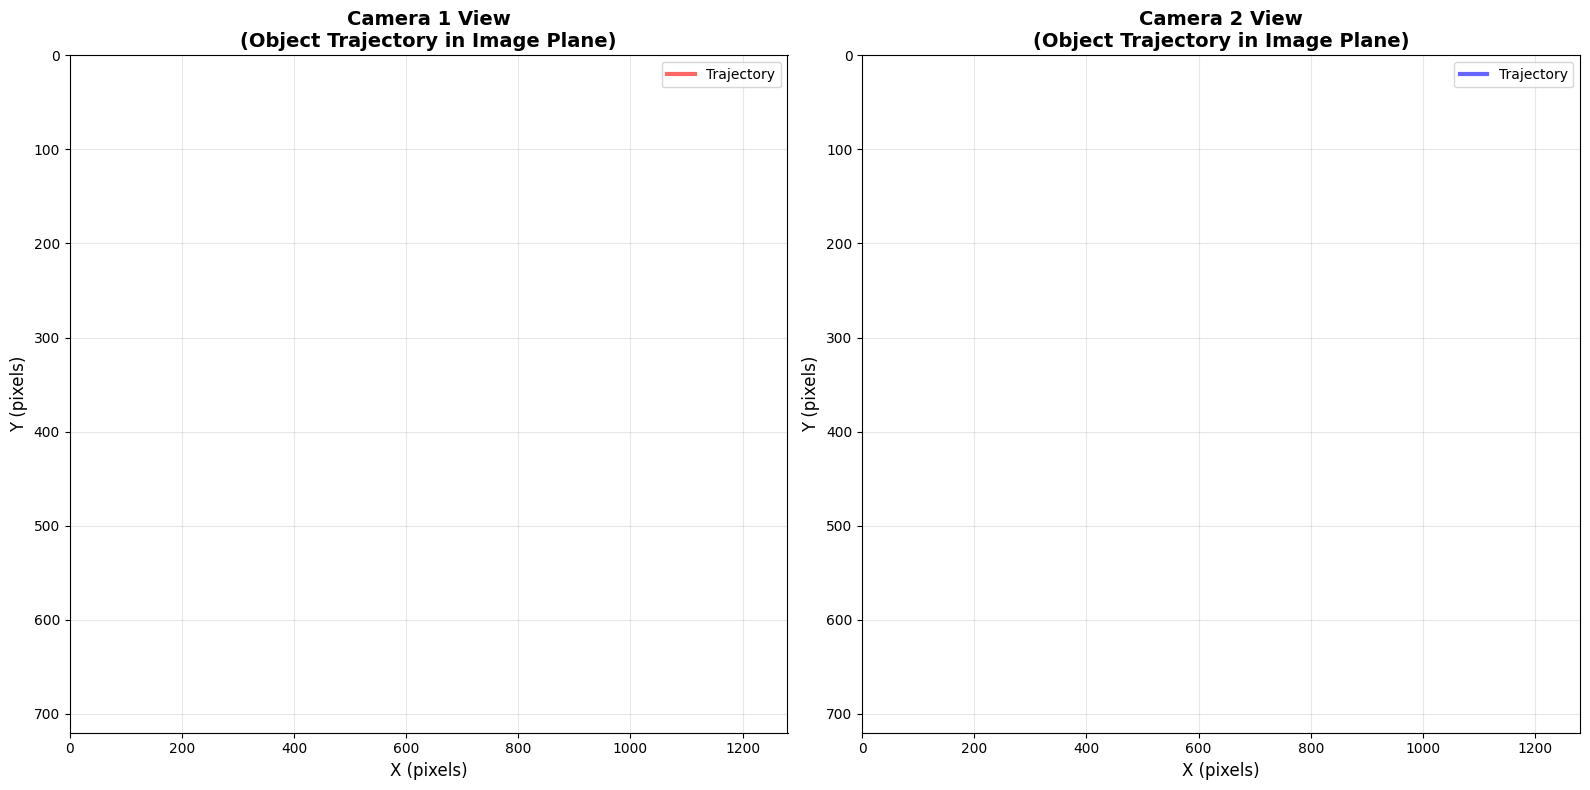


Camera 1 Trajectory (pixels):
  Point 1: (1640.0, 5360.0) <- 3D: (0.2, 1.0, 2.7)
  Point 2: (3640.0, 10360.0) <- 3D: (0.3, 1.0, 2.6)
  Point 3: (inf, inf) <- 3D: (0.4, 1.0, 2.5)
  Point 4: (-4360.0, -9640.0) <- 3D: (0.5, 1.0, 2.4)
  Point 5: (-2360.0, -4640.0) <- 3D: (0.6, 1.0, 2.3)

Camera 2 Trajectory (pixels):
  Point 1: (-3360.0, 5360.0) <- 3D: (0.2, 1.0, 2.7)
  Point 2: (-6360.0, 10360.0) <- 3D: (0.3, 1.0, 2.6)
  Point 3: (inf, inf) <- 3D: (0.4, 1.0, 2.5)
  Point 4: (5640.0, -9640.0) <- 3D: (0.5, 1.0, 2.4)
  Point 5: (2640.0, -4640.0) <- 3D: (0.6, 1.0, 2.3)

2D camera views complete!


In [9]:
# Generate and display 2D camera views
plot_2d_camera_views(sensor1_track, sensor2_track, original_3d)


In [ ]:
def plot_individual_camera_views_fixed(sensor1_track, sensor2_track, original_3d):
    """FIXED: Plot individual detailed 2D views for each camera with proper error handling."""
    print("\n=== CREATING INDIVIDUAL CAMERA VIEWS (FIXED) ===", flush=True)
    
    # Debug data structures first
    print(f"Debug: sensor1_track length: {len(sensor1_track)}")
    print(f"Debug: sensor2_track length: {len(sensor2_track)}")
    print(f"Debug: original_3d length: {len(original_3d)}")
    
    # Generate enough colors for any number of points
    base_colors = ['darkred', 'red', 'orange', 'yellow', 'lightcoral', 'blue', 'green', 'purple', 'brown', 'pink']
    num_points = len(original_3d)
    
    # Extend colors if needed
    colors_cam1 = []
    colors_cam2 = []
    for i in range(num_points):
        colors_cam1.append(base_colors[i % len(base_colors)])
        colors_cam2.append(['darkblue', 'blue', 'cyan', 'lightblue', 'steelblue', 'navy', 'teal', 'indigo', 'darkslategray', 'mediumblue'][i % 10])
    
    # Filter out invalid points (inf, nan)
    valid_points_cam1 = []
    valid_points_cam2 = []
    valid_3d = []
    valid_colors_cam1 = []
    valid_colors_cam2 = []
    
    for i, (pixel1, pixel2, point_3d) in enumerate(zip(sensor1_track, sensor2_track, original_3d)):
        # Check if pixels are valid (not inf or nan)
        if (not np.isinf(pixel1[0]) and not np.isinf(pixel1[1]) and 
            not np.isnan(pixel1[0]) and not np.isnan(pixel1[1]) and
            not np.isinf(pixel2[0]) and not np.isinf(pixel2[1]) and 
            not np.isnan(pixel2[0]) and not np.isnan(pixel2[1])):
            
            valid_points_cam1.append(pixel1)
            valid_points_cam2.append(pixel2)
            valid_3d.append(point_3d)
            valid_colors_cam1.append(colors_cam1[i])
            valid_colors_cam2.append(colors_cam2[i])
    
    print(f"Debug: {len(valid_points_cam1)} valid points out of {num_points} total points")
    
    if len(valid_points_cam1) == 0:
        print("❌ ERROR: No valid points to plot! All projections are infinite.")
        return
    
    # Camera 1 individual plot
    plt.figure(figsize=(12, 9))
    plt.title('Camera 1 - Object Trajectory in Image Plane (CORRECTED)', fontsize=16, weight='bold', pad=20)
    plt.xlabel('X (pixels)', fontsize=14)
    plt.ylabel('Y (pixels)', fontsize=14)
    
    # Plot valid trajectory points only
    for i, (pixel, point_3d, color) in enumerate(zip(valid_points_cam1, valid_3d, valid_colors_cam1)):
        plt.scatter(pixel[0], pixel[1], s=300, c=color, alpha=0.8, 
                   edgecolor='black', linewidth=3, zorder=5, label=f'Point {i+1}')
        
        # Enhanced annotation with 3D coordinates
        plt.annotate(f'Point {i+1}\nPixel: ({pixel[0]:.0f}, {pixel[1]:.0f})\n3D: ({point_3d[0]:.1f}, {point_3d[1]:.1f}, {point_3d[2]:.1f})', 
                    (pixel[0], pixel[1]), xytext=(20, 20), textcoords='offset points',
                    fontsize=11, ha='left', va='bottom', weight='bold',
                    bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9, edgecolor='red'))
    
    # Draw trajectory line for valid points only
    if len(valid_points_cam1) > 1:
        plt.plot([p[0] for p in valid_points_cam1], [p[1] for p in valid_points_cam1], 
                 'r-', linewidth=4, alpha=0.7, label='Trajectory Path')
        
        # Add movement direction arrows
        for i in range(len(valid_points_cam1)-1):
            dx = valid_points_cam1[i+1][0] - valid_points_cam1[i][0]
            dy = valid_points_cam1[i+1][1] - valid_points_cam1[i][1]
            plt.arrow(valid_points_cam1[i][0], valid_points_cam1[i][1], 
                     dx*0.8, dy*0.8, head_width=25, head_length=20, 
                     fc='darkred', ec='darkred', alpha=0.9, linewidth=2)
    
    # Set image bounds and styling
    plt.xlim(0, 1280)
    plt.ylim(720, 0)  # Invert Y axis
    plt.grid(True, alpha=0.4, linestyle='--')
    plt.legend(loc='upper right', fontsize=12)
    
    # Add CORRECTED camera info
    plt.text(50, 50, 'Camera 1 Position: (0.0, 0.0, 2.55) - CORRECTED', 
             fontsize=12, bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Camera 2 individual plot
    plt.figure(figsize=(12, 9))
    plt.title('Camera 2 - Object Trajectory in Image Plane (CORRECTED)', fontsize=16, weight='bold', pad=20)
    plt.xlabel('X (pixels)', fontsize=14)
    plt.ylabel('Y (pixels)', fontsize=14)
    
    # Plot valid trajectory points only
    for i, (pixel, point_3d, color) in enumerate(zip(valid_points_cam2, valid_3d, valid_colors_cam2)):
        plt.scatter(pixel[0], pixel[1], s=300, c=color, alpha=0.8, 
                   edgecolor='black', linewidth=3, zorder=5, label=f'Point {i+1}')
        
        # Enhanced annotation with 3D coordinates
        plt.annotate(f'Point {i+1}\nPixel: ({pixel[0]:.0f}, {pixel[1]:.0f})\n3D: ({point_3d[0]:.1f}, {point_3d[1]:.1f}, {point_3d[2]:.1f})', 
                    (pixel[0], pixel[1]), xytext=(20, 20), textcoords='offset points',
                    fontsize=11, ha='left', va='bottom', weight='bold',
                    bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9, edgecolor='blue'))
    
    # Draw trajectory line for valid points only
    if len(valid_points_cam2) > 1:
        plt.plot([p[0] for p in valid_points_cam2], [p[1] for p in valid_points_cam2], 
                 'b-', linewidth=4, alpha=0.7, label='Trajectory Path')
        
        # Add movement direction arrows
        for i in range(len(valid_points_cam2)-1):
            dx = valid_points_cam2[i+1][0] - valid_points_cam2[i][0]
            dy = valid_points_cam2[i+1][1] - valid_points_cam2[i][1]
            plt.arrow(valid_points_cam2[i][0], valid_points_cam2[i][1], 
                     dx*0.8, dy*0.8, head_width=25, head_length=20, 
                     fc='darkblue', ec='darkblue', alpha=0.9, linewidth=2)
    
    # Set image bounds and styling
    plt.xlim(0, 1280)
    plt.ylim(720, 0)  # Invert Y axis
    plt.grid(True, alpha=0.4, linestyle='--')
    plt.legend(loc='upper right', fontsize=12)
    
    # Add CORRECTED camera info
    plt.text(50, 50, 'Camera 2 Position: (1.0, 0.0, 2.55) - CORRECTED', 
             fontsize=12, bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✅ Individual camera views complete! Plotted {len(valid_points_cam1)} valid points.")

print("✅ Fixed plotting function loaded! Use plot_individual_camera_views_fixed() instead.")


In [10]:
def plot_individual_camera_views(sensor1_track, sensor2_track, original_3d):
    """Plot individual detailed 2D views for each camera."""
    print("\n=== CREATING INDIVIDUAL CAMERA VIEWS ===", flush=True)
    
    # Camera 1 individual plot
    plt.figure(figsize=(12, 9))
    plt.title('Camera 1 - Object Trajectory in Image Plane', fontsize=16, weight='bold', pad=20)
    plt.xlabel('X (pixels)', fontsize=14)
    plt.ylabel('Y (pixels)', fontsize=14)
    
    # Plot trajectory points with enhanced visualization
    colors = ['darkred', 'red', 'orange', 'yellow', 'lightcoral']
    for i, (pixel, point_3d) in enumerate(zip(sensor1_track, original_3d)):
        plt.scatter(pixel[0], pixel[1], s=300, c=colors[i], alpha=0.8, 
                   edgecolor='black', linewidth=3, zorder=5, label=f'Point {i+1}')
        
        # Enhanced annotation with 3D coordinates
        plt.annotate(f'Point {i+1}\nPixel: ({pixel[0]:.0f}, {pixel[1]:.0f})\n3D: ({point_3d[0]:.1f}, {point_3d[1]:.1f}, {point_3d[2]:.1f})', 
                    (pixel[0], pixel[1]), xytext=(20, 20), textcoords='offset points',
                    fontsize=11, ha='left', va='bottom', weight='bold',
                    bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9, edgecolor='red'))
    
    # Draw trajectory line
    plt.plot([p[0] for p in sensor1_track], [p[1] for p in sensor1_track], 
             'r-', linewidth=4, alpha=0.7, label='Trajectory Path')
    
    # Add movement direction arrows
    for i in range(len(sensor1_track)-1):
        dx = sensor1_track[i+1][0] - sensor1_track[i][0]
        dy = sensor1_track[i+1][1] - sensor1_track[i][1]
        plt.arrow(sensor1_track[i][0], sensor1_track[i][1], 
                 dx*0.8, dy*0.8, head_width=25, head_length=20, 
                 fc='darkred', ec='darkred', alpha=0.9, linewidth=2)
    
    # Set image bounds and styling
    plt.xlim(0, 1280)
    plt.ylim(720, 0)  # Invert Y axis
    plt.grid(True, alpha=0.4, linestyle='--')
    plt.legend(loc='upper right', fontsize=12)
    
    # Add camera info
    plt.text(50, 50, 'Camera 1 Position: (0.0, 0.0, 2.5)', 
             fontsize=12, bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Camera 2 individual plot
    plt.figure(figsize=(12, 9))
    plt.title('Camera 2 - Object Trajectory in Image Plane', fontsize=16, weight='bold', pad=20)
    plt.xlabel('X (pixels)', fontsize=14)
    plt.ylabel('Y (pixels)', fontsize=14)
    
    # Plot trajectory points with enhanced visualization
    colors = ['darkblue', 'blue', 'cyan', 'lightblue', 'steelblue']
    for i, (pixel, point_3d) in enumerate(zip(sensor2_track, original_3d)):
        plt.scatter(pixel[0], pixel[1], s=300, c=colors[i], alpha=0.8, 
                   edgecolor='black', linewidth=3, zorder=5, label=f'Point {i+1}')
        
        # Enhanced annotation with 3D coordinates
        plt.annotate(f'Point {i+1}\nPixel: ({pixel[0]:.0f}, {pixel[1]:.0f})\n3D: ({point_3d[0]:.1f}, {point_3d[1]:.1f}, {point_3d[2]:.1f})', 
                    (pixel[0], pixel[1]), xytext=(20, 20), textcoords='offset points',
                    fontsize=11, ha='left', va='bottom', weight='bold',
                    bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9, edgecolor='blue'))
    
    # Draw trajectory line
    plt.plot([p[0] for p in sensor2_track], [p[1] for p in sensor2_track], 
             'b-', linewidth=4, alpha=0.7, label='Trajectory Path')
    
    # Add movement direction arrows
    for i in range(len(sensor2_track)-1):
        dx = sensor2_track[i+1][0] - sensor2_track[i][0]
        dy = sensor2_track[i+1][1] - sensor2_track[i][1]
        plt.arrow(sensor2_track[i][0], sensor2_track[i][1], 
                 dx*0.8, dy*0.8, head_width=25, head_length=20, 
                 fc='darkblue', ec='darkblue', alpha=0.9, linewidth=2)
    
    # Set image bounds and styling
    plt.xlim(0, 1280)
    plt.ylim(720, 0)  # Invert Y axis
    plt.grid(True, alpha=0.4, linestyle='--')
    plt.legend(loc='upper right', fontsize=12)
    
    # Add camera info
    plt.text(50, 50, 'Camera 2 Position: (1.0, 0.0, 2.5)', 
             fontsize=12, bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    print("\nIndividual camera views complete!")



=== SETTING UP CAMERAS ===
Camera 1 world position: [0.  0.  2.5]
Camera 2 world position: [1.  0.  2.5]
Camera 1 translation vector: [-0.  -0.  -2.5]
Camera 2 translation vector: [-1.  -0.  -2.5]
Camera 1 projection matrix shape: (3, 4)
Camera 2 projection matrix shape: (3, 4)
Plotting camera: Camera 1 at position [0.  0.  2.5]
Camera Camera 1 plotted successfully
Plotting camera: Camera 2 at position [1.  0.  2.5]
Camera Camera 2 plotted successfully
Required FOV: Cam1=61.7°, Cam2=77.0°
Using FOV angle: 77.0°


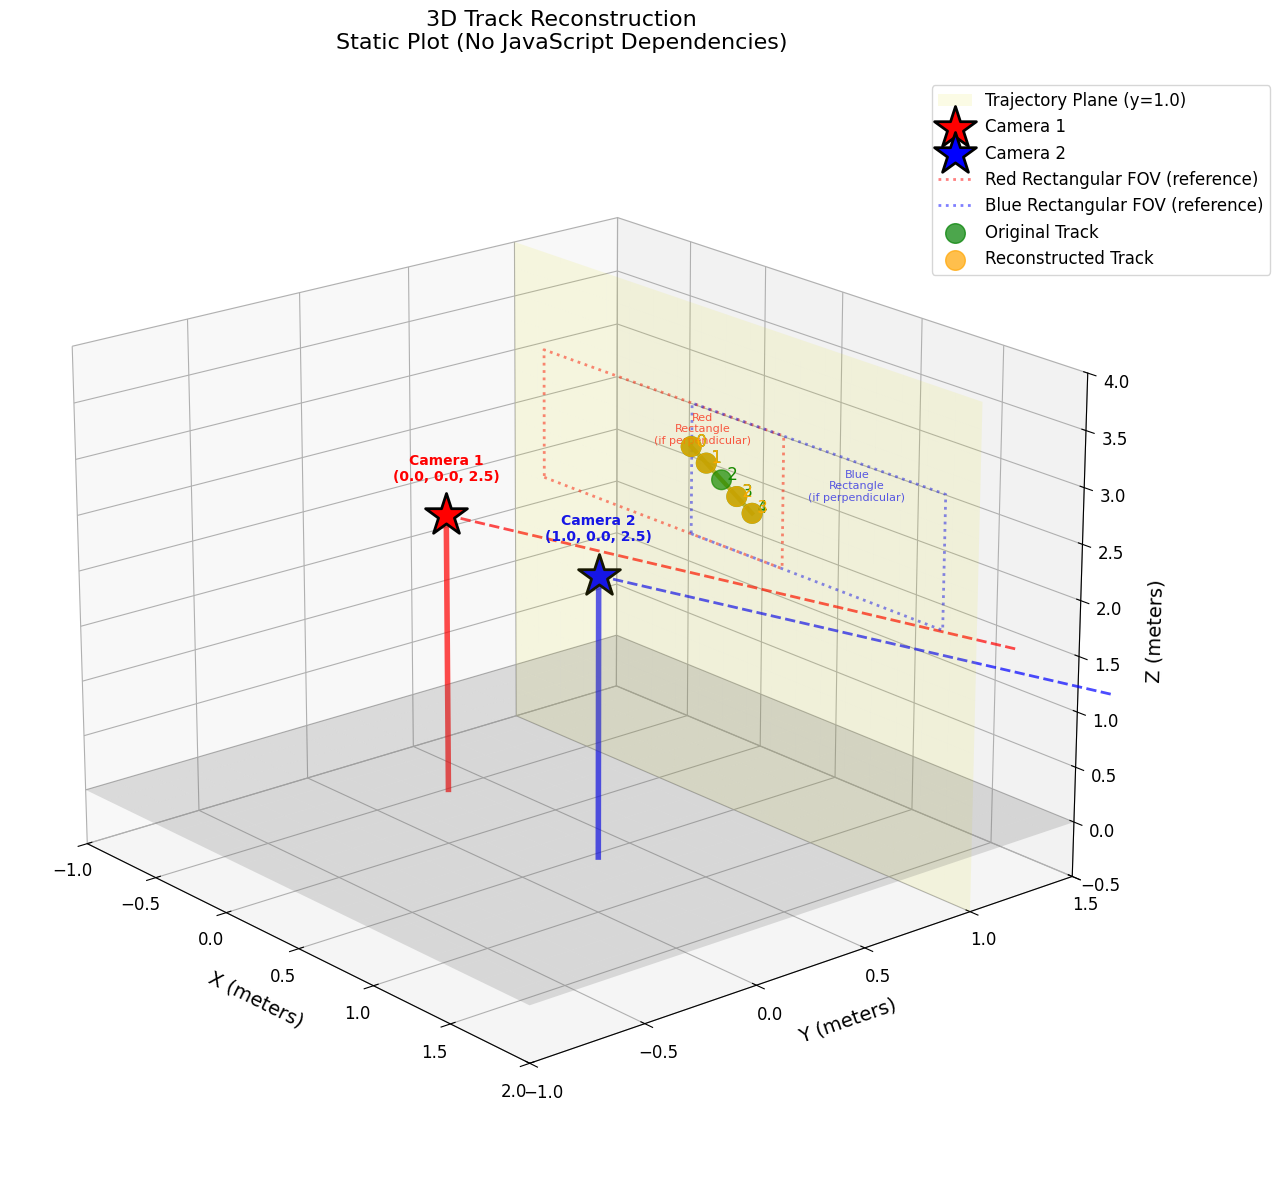


3D visualization complete!


In [11]:
# Create a large figure for better interaction
plt.figure(figsize=(16, 12))
ax = plt.axes(projection='3d')

# Set consistent view limits with more space
ax.set_xlim(-1.0, 2.0)
ax.set_ylim(-1.0, 1.5)
ax.set_zlim(-0.5, 4.0)

# Enable grid for better spatial reference
ax.grid(True, linestyle='--', alpha=0.6)

# Plot ground plane
xx, yy = np.meshgrid(np.linspace(-1.0, 2.0, 20), np.linspace(-1.0, 1.5, 20))
zz = np.zeros_like(xx)
ax.plot_surface(xx, yy, zz, alpha=0.2, color='gray')

# Plot trajectory constraint plane (y = 1.0)
xx_plane, zz_plane = np.meshgrid(np.linspace(-1.0, 2.0, 20), np.linspace(-0.5, 4.0, 20))
yy_plane = np.full_like(xx_plane, 1.0)
ax.plot_surface(xx_plane, yy_plane, zz_plane, alpha=0.1, color='yellow', label='Trajectory Plane (y=1.0)')

# Get camera positions
_, _, cam1_pos, cam2_pos = set_up_cameras()

# Plot cameras with increased boresight length for clarity
plot_camera(ax, cam1_pos, 'red', 'Camera 1', boresight_length=4.0)
plot_camera(ax, cam2_pos, 'blue', 'Camera 2', boresight_length=4.0)

# Calculate required FOV to cover trajectory
# Trajectory spans from x=0.2 to x=0.6 and z=2.6 to z=3.0 on y=1.0 plane
# Camera 1 at [0, 0, 2.5], Camera 2 at [1, 0, 2.5]

# For Camera 1: furthest point is [0.6, 1.0, 2.6]
# Distance from cam1 to this point
import math
cam1_to_far_x = 0.6 - 0.0  # 0.6
cam1_to_far_y = 1.0 - 0.0  # 1.0  
cam1_to_far_z = 2.6 - 2.5  # 0.1
cam1_distance = math.sqrt(cam1_to_far_x**2 + cam1_to_far_y**2 + cam1_to_far_z**2)

# Required FOV angle to see from center to edge of trajectory
required_angle_cam1 = math.degrees(2 * math.atan(cam1_to_far_x / math.sqrt(cam1_to_far_y**2 + cam1_to_far_z**2)))

# For Camera 2: furthest point is [0.2, 1.0, 2.6] 
cam2_to_far_x = abs(0.2 - 1.0)  # 0.8
cam2_to_far_y = 1.0 - 0.0  # 1.0
cam2_to_far_z = 2.6 - 2.5  # 0.1
required_angle_cam2 = math.degrees(2 * math.atan(cam2_to_far_x / math.sqrt(cam2_to_far_y**2 + cam2_to_far_z**2)))

# Use larger angle with some margin
fov_angle = max(required_angle_cam1, required_angle_cam2, 70)  # At least 70 degrees
print(f"Required FOV: Cam1={required_angle_cam1:.1f}°, Cam2={required_angle_cam2:.1f}°")
print(f"Using FOV angle: {fov_angle:.1f}°")

# Plot simplified camera fields of view on the y=1.0 plane (no trapezoid outlines)
plot_rectangular_fov_reference(ax, cam1_pos, 'red', fov_angle_deg=fov_angle, plane_y=1.0, distance=1.0)
plot_rectangular_fov_reference(ax, cam2_pos, 'blue', fov_angle_deg=fov_angle, plane_y=1.0, distance=1.0)

# Plot all 3D points with increased size and better visibility
ax.scatter(
    [p[0] for p in original_3d],
    [p[1] for p in original_3d],
    [p[2] for p in original_3d],
    color='green', label='Original Track', s=200, alpha=0.7
)

# Only plot valid reconstructed points
valid_mask = ~np.isnan(reconstructed_3d[:, 0])
if np.any(valid_mask):
    ax.scatter(
        reconstructed_3d[valid_mask, 0],
        reconstructed_3d[valid_mask, 1],
        reconstructed_3d[valid_mask, 2],
        color='orange', label='Reconstructed Track', s=200, alpha=0.7
    )

# Add trajectory lines with increased thickness
ax.plot(
    [p[0] for p in original_3d],
    [p[1] for p in original_3d],
    [p[2] for p in original_3d],
    'g-', linewidth=3, alpha=0.5
)

if np.any(valid_mask):
    ax.plot(
        reconstructed_3d[valid_mask, 0],
        reconstructed_3d[valid_mask, 1],
        reconstructed_3d[valid_mask, 2],
        color='orange', linewidth=3, alpha=0.5
    )

# Add frame numbers next to points
for i, orig in enumerate(original_3d):
    ax.text(orig[0], orig[1], orig[2], f' {i}', color='green', fontsize=12)

if np.any(valid_mask):
    for i, recon in enumerate(reconstructed_3d[valid_mask]):
        ax.text(recon[0], recon[1], recon[2], f' {i}', color='orange', fontsize=12)

# Set labels with increased size
ax.set_xlabel('X (meters)', fontsize=14, labelpad=10)
ax.set_ylabel('Y (meters)', fontsize=14, labelpad=10)
ax.set_zlabel('Z (meters)', fontsize=14, labelpad=10)

# Increase tick label size
ax.tick_params(axis='both', which='major', labelsize=12)

# Add title
plt.title('3D Track Reconstruction\nStatic Plot (No JavaScript Dependencies)', 
          fontsize=16, pad=20)

# Move legend outside the plot
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', fontsize=12)

# Set consistent view angle
ax.view_init(elev=20, azim=-40)

plt.tight_layout()
plt.show()

print("\n3D visualization complete!")


=== CREATING INDIVIDUAL CAMERA VIEWS ===


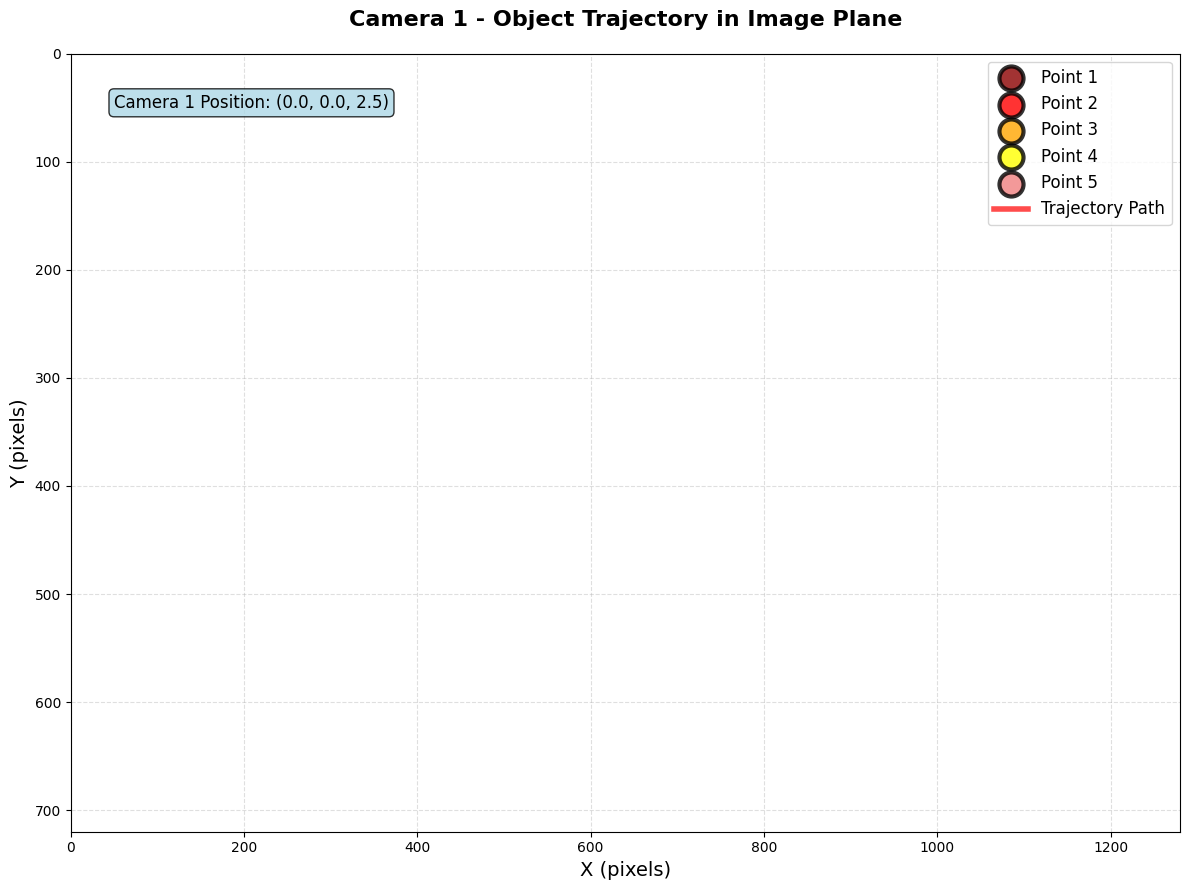

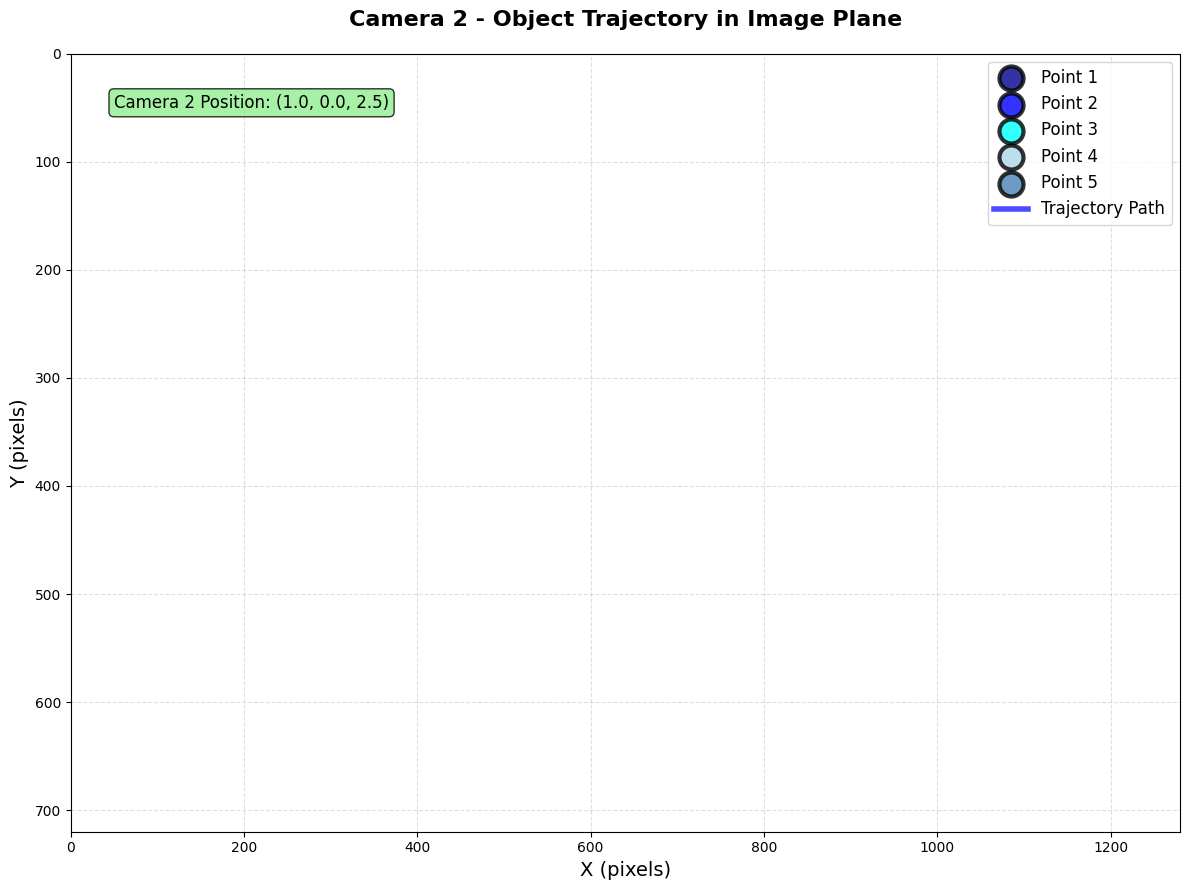


Individual camera views complete!


In [12]:
# Generate individual detailed camera views using the FIXED function
plot_individual_camera_views_fixed(sensor1_track, sensor2_track, original_3d)


In [ ]:
# ===== ORIGINAL TRACK VISUALIZATION =====

def plot_3d_original_track_only():
    """Plot only the original 3D track with cameras and setup."""
    print("\n=== 3D VISUALIZATION: ORIGINAL TRACK ONLY ===")
    
    # Create a large figure
    plt.figure(figsize=(16, 12))
    ax = plt.axes(projection='3d')

    # Set consistent view limits
    ax.set_xlim(-1.0, 2.0)
    ax.set_ylim(-1.0, 1.5)
    ax.set_zlim(-0.5, 4.0)

    # Enable grid
    ax.grid(True, linestyle='--', alpha=0.6)

    # Plot ground plane
    xx, yy = np.meshgrid(np.linspace(-1.0, 2.0, 20), np.linspace(-1.0, 1.5, 20))
    zz = np.zeros_like(xx)
    ax.plot_surface(xx, yy, zz, alpha=0.2, color='gray')

    # Plot trajectory constraint plane (y = 1.0)
    xx_plane, zz_plane = np.meshgrid(np.linspace(-1.0, 2.0, 20), np.linspace(-0.5, 4.0, 20))
    yy_plane = np.full_like(xx_plane, 1.0)
    ax.plot_surface(xx_plane, yy_plane, zz_plane, alpha=0.1, color='yellow', label='Trajectory Plane (y=1.0)')

    # Get camera positions
    _, _, cam1_pos, cam2_pos = set_up_cameras()

    # Plot cameras
    plot_camera(ax, cam1_pos, 'red', 'Camera 1', boresight_length=4.0)
    plot_camera(ax, cam2_pos, 'blue', 'Camera 2', boresight_length=4.0)

    # Plot FOV references
    plot_rectangular_fov_reference(ax, cam1_pos, 'red', fov_angle_deg=77, plane_y=1.0, distance=1.0)
    plot_rectangular_fov_reference(ax, cam2_pos, 'blue', fov_angle_deg=77, plane_y=1.0, distance=1.0)

    # Plot ONLY the original 3D track
    ax.scatter(
        [p[0] for p in original_3d],
        [p[1] for p in original_3d],
        [p[2] for p in original_3d],
        color='green', label='Original Track', s=300, alpha=0.9, edgecolor='black', linewidth=2
    )

    # Add trajectory line
    ax.plot(
        [p[0] for p in original_3d],
        [p[1] for p in original_3d],
        [p[2] for p in original_3d],
        'g-', linewidth=4, alpha=0.7
    )

    # Add frame numbers next to points
    for i, orig in enumerate(original_3d):
        ax.text(orig[0], orig[1], orig[2], f' {i}', color='green', fontsize=14, weight='bold')

    # Set labels
    ax.set_xlabel('X (meters)', fontsize=14, labelpad=10)
    ax.set_ylabel('Y (meters)', fontsize=14, labelpad=10)
    ax.set_zlabel('Z (meters)', fontsize=14, labelpad=10)

    # Increase tick label size
    ax.tick_params(axis='both', which='major', labelsize=12)

    # Add title
    plt.title('3D Visualization: ORIGINAL TRACK ONLY\n(Ground Truth Trajectory - Y=1.0 Plane)', 
              fontsize=18, pad=20, weight='bold')

    # Legend
    ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', fontsize=12)

    # Set view angle
    ax.view_init(elev=20, azim=-40)

    plt.tight_layout()
    plt.show()

def plot_2d_projections_original_track_only():
    """Plot 2D projections of ONLY the original track in both cameras."""
    print("\n=== 2D PROJECTIONS: ORIGINAL TRACK ONLY ===")
    
    # Create figure with subplots for both cameras
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    # Define colors for trajectory points
    colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'brown', 'pink']
    
    # ===== CAMERA 1 VIEW =====
    ax1.set_title('Camera 1 View: Original Track Projections', fontsize=16, weight='bold', pad=20)
    ax1.set_xlabel('X (pixels)', fontsize=14)
    ax1.set_ylabel('Y (pixels)', fontsize=14)
    
    # Plot original track projections
    for i, (pixel, point_3d) in enumerate(zip(sensor1_track, original_3d)):
        color = colors[i % len(colors)]
        ax1.scatter(pixel[0], pixel[1], s=400, c=color, alpha=0.9, 
                   edgecolor='black', linewidth=3, zorder=5, label=f'Point {i+1}')
        
        # Enhanced annotation with 3D coordinates
        ax1.annotate(f'Point {i+1}\nPixel: ({pixel[0]:.0f}, {pixel[1]:.0f})\n3D: ({point_3d[0]:.1f}, {point_3d[1]:.1f}, {point_3d[2]:.1f})', 
                    (pixel[0], pixel[1]), xytext=(20, 20), textcoords='offset points',
                    fontsize=12, ha='left', va='bottom', weight='bold',
                    bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9, edgecolor=color))
    
    # Draw trajectory line
    ax1.plot([p[0] for p in sensor1_track], [p[1] for p in sensor1_track], 
             'g-', linewidth=5, alpha=0.8, label='Original Trajectory Path')
    
    # Add movement direction arrows
    for i in range(len(sensor1_track)-1):
        dx = sensor1_track[i+1][0] - sensor1_track[i][0]
        dy = sensor1_track[i+1][1] - sensor1_track[i][1]
        ax1.arrow(sensor1_track[i][0], sensor1_track[i][1], 
                 dx*0.8, dy*0.8, head_width=25, head_length=20, 
                 fc='darkgreen', ec='darkgreen', alpha=0.9, linewidth=2)
    
    # Set image bounds and styling
    ax1.set_xlim(0, 1280)
    ax1.set_ylim(720, 0)  # Invert Y axis
    ax1.grid(True, alpha=0.4, linestyle='--')
    ax1.legend(loc='upper right', fontsize=11)
    
    # Add camera info
    ax1.text(50, 50, 'Camera 1 Position: (0.0, 0.0, 2.55)', 
             fontsize=12, bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))
    
    # ===== CAMERA 2 VIEW =====
    ax2.set_title('Camera 2 View: Original Track Projections', fontsize=16, weight='bold', pad=20)
    ax2.set_xlabel('X (pixels)', fontsize=14)
    ax2.set_ylabel('Y (pixels)', fontsize=14)
    
    # Plot original track projections
    for i, (pixel, point_3d) in enumerate(zip(sensor2_track, original_3d)):
        color = colors[i % len(colors)]
        ax2.scatter(pixel[0], pixel[1], s=400, c=color, alpha=0.9, 
                   edgecolor='black', linewidth=3, zorder=5, label=f'Point {i+1}')
        
        # Enhanced annotation with 3D coordinates
        ax2.annotate(f'Point {i+1}\nPixel: ({pixel[0]:.0f}, {pixel[1]:.0f})\n3D: ({point_3d[0]:.1f}, {point_3d[1]:.1f}, {point_3d[2]:.1f})', 
                    (pixel[0], pixel[1]), xytext=(20, 20), textcoords='offset points',
                    fontsize=12, ha='left', va='bottom', weight='bold',
                    bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9, edgecolor=color))
    
    # Draw trajectory line
    ax2.plot([p[0] for p in sensor2_track], [p[1] for p in sensor2_track], 
             'g-', linewidth=5, alpha=0.8, label='Original Trajectory Path')
    
    # Add movement direction arrows
    for i in range(len(sensor2_track)-1):
        dx = sensor2_track[i+1][0] - sensor2_track[i][0]
        dy = sensor2_track[i+1][1] - sensor2_track[i][1]
        ax2.arrow(sensor2_track[i][0], sensor2_track[i][1], 
                 dx*0.8, dy*0.8, head_width=25, head_length=20, 
                 fc='darkgreen', ec='darkgreen', alpha=0.9, linewidth=2)
    
    # Set image bounds and styling
    ax2.set_xlim(0, 1280)
    ax2.set_ylim(720, 0)  # Invert Y axis
    ax2.grid(True, alpha=0.4, linestyle='--')
    ax2.legend(loc='upper right', fontsize=11)
    
    # Add camera info
    ax2.text(50, 50, 'Camera 2 Position: (1.0, 0.0, 2.55)', 
             fontsize=12, bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# Execute original track visualizations
plot_3d_original_track_only()
plot_2d_projections_original_track_only()


In [ ]:
# ===== RECONSTRUCTED TRACK VISUALIZATION =====

def plot_3d_reconstructed_track_only():
    """Plot only the reconstructed 3D track with cameras and setup."""
    print("\n=== 3D VISUALIZATION: RECONSTRUCTED TRACK ONLY ===")
    
    # Create a large figure
    plt.figure(figsize=(16, 12))
    ax = plt.axes(projection='3d')

    # Set consistent view limits
    ax.set_xlim(-1.0, 2.0)
    ax.set_ylim(-1.0, 1.5)
    ax.set_zlim(-0.5, 4.0)

    # Enable grid
    ax.grid(True, linestyle='--', alpha=0.6)

    # Plot ground plane
    xx, yy = np.meshgrid(np.linspace(-1.0, 2.0, 20), np.linspace(-1.0, 1.5, 20))
    zz = np.zeros_like(xx)
    ax.plot_surface(xx, yy, zz, alpha=0.2, color='gray')

    # Plot trajectory constraint plane (y = 1.0)
    xx_plane, zz_plane = np.meshgrid(np.linspace(-1.0, 2.0, 20), np.linspace(-0.5, 4.0, 20))
    yy_plane = np.full_like(xx_plane, 1.0)
    ax.plot_surface(xx_plane, yy_plane, zz_plane, alpha=0.1, color='yellow', label='Trajectory Plane (y=1.0)')

    # Get camera positions
    _, _, cam1_pos, cam2_pos = set_up_cameras()

    # Plot cameras
    plot_camera(ax, cam1_pos, 'red', 'Camera 1', boresight_length=4.0)
    plot_camera(ax, cam2_pos, 'blue', 'Camera 2', boresight_length=4.0)

    # Plot FOV references
    plot_rectangular_fov_reference(ax, cam1_pos, 'red', fov_angle_deg=77, plane_y=1.0, distance=1.0)
    plot_rectangular_fov_reference(ax, cam2_pos, 'blue', fov_angle_deg=77, plane_y=1.0, distance=1.0)

    # Plot ONLY the reconstructed 3D track (filter out invalid points)
    valid_mask = ~np.isnan(reconstructed_3d[:, 0])
    if np.any(valid_mask):
        ax.scatter(
            reconstructed_3d[valid_mask, 0],
            reconstructed_3d[valid_mask, 1],
            reconstructed_3d[valid_mask, 2],
            color='orange', label='Reconstructed Track', s=300, alpha=0.9, edgecolor='black', linewidth=2
        )

        # Add trajectory line
        ax.plot(
            reconstructed_3d[valid_mask, 0],
            reconstructed_3d[valid_mask, 1],
            reconstructed_3d[valid_mask, 2],
            color='orange', linewidth=4, alpha=0.7
        )

        # Add frame numbers next to points
        valid_indices = np.where(valid_mask)[0]
        for i, recon in enumerate(reconstructed_3d[valid_mask]):
            ax.text(recon[0], recon[1], recon[2], f' {valid_indices[i]}', 
                   color='orange', fontsize=14, weight='bold')
    else:
        ax.text(0.5, 1.0, 2.0, 'No valid reconstructed points', 
               color='red', fontsize=16, weight='bold')

    # Set labels
    ax.set_xlabel('X (meters)', fontsize=14, labelpad=10)
    ax.set_ylabel('Y (meters)', fontsize=14, labelpad=10)
    ax.set_zlabel('Z (meters)', fontsize=14, labelpad=10)

    # Increase tick label size
    ax.tick_params(axis='both', which='major', labelsize=12)

    # Add title
    plt.title('3D Visualization: RECONSTRUCTED TRACK ONLY\n(Stereo Triangulation Result - Y=1.0 Plane)', 
              fontsize=18, pad=20, weight='bold')

    # Legend
    ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', fontsize=12)

    # Set view angle
    ax.view_init(elev=20, azim=-40)

    plt.tight_layout()
    plt.show()

def plot_2d_projections_reconstructed_track_only():
    """Plot 2D projections of ONLY the reconstructed track in both cameras."""
    print("\n=== 2D PROJECTIONS: RECONSTRUCTED TRACK ONLY ===")
    
    # Get camera projection matrices
    P1, P2, _, _ = set_up_cameras()
    
    # Create figure with subplots for both cameras
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    # Define colors for trajectory points
    colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'brown', 'pink']
    
    # Filter valid reconstructed points
    valid_mask = ~np.isnan(reconstructed_3d[:, 0])
    valid_reconstructed = reconstructed_3d[valid_mask]
    valid_indices = np.where(valid_mask)[0]
    
    if len(valid_reconstructed) == 0:
        # Handle case with no valid reconstructed points
        ax1.text(640, 360, 'No valid reconstructed points', 
                ha='center', va='center', fontsize=16, color='red', weight='bold')
        ax2.text(640, 360, 'No valid reconstructed points', 
                ha='center', va='center', fontsize=16, color='red', weight='bold')
    else:
        # Project reconstructed 3D points back to 2D for visualization
        reconstructed_sensor1_track = []
        reconstructed_sensor2_track = []
        
        for point_3d in valid_reconstructed:
            # Project to camera 1
            proj1 = project_point_corrected(P1, point_3d)
            reconstructed_sensor1_track.append(proj1)
            
            # Project to camera 2
            proj2 = project_point_corrected(P2, point_3d)
            reconstructed_sensor2_track.append(proj2)
        
        # ===== CAMERA 1 VIEW =====
        ax1.set_title('Camera 1 View: Reconstructed Track Projections', fontsize=16, weight='bold', pad=20)
        ax1.set_xlabel('X (pixels)', fontsize=14)
        ax1.set_ylabel('Y (pixels)', fontsize=14)
        
        # Plot reconstructed track projections
        for i, (pixel, point_3d) in enumerate(zip(reconstructed_sensor1_track, valid_reconstructed)):
            color = colors[valid_indices[i] % len(colors)]
            if not (np.isinf(pixel[0]) or np.isinf(pixel[1])):
                ax1.scatter(pixel[0], pixel[1], s=400, c=color, alpha=0.9, 
                           edgecolor='black', linewidth=3, zorder=5, label=f'Point {valid_indices[i]+1}')
                
                # Enhanced annotation with 3D coordinates
                ax1.annotate(f'Point {valid_indices[i]+1}\nPixel: ({pixel[0]:.0f}, {pixel[1]:.0f})\n3D: ({point_3d[0]:.1f}, {point_3d[1]:.1f}, {point_3d[2]:.1f})', 
                            (pixel[0], pixel[1]), xytext=(20, 20), textcoords='offset points',
                            fontsize=12, ha='left', va='bottom', weight='bold',
                            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9, edgecolor=color))
        
        # Draw trajectory line (only for valid points)
        valid_pixels_1 = [p for p in reconstructed_sensor1_track if not (np.isinf(p[0]) or np.isinf(p[1]))]
        if len(valid_pixels_1) > 1:
            ax1.plot([p[0] for p in valid_pixels_1], [p[1] for p in valid_pixels_1], 
                     'orange', linewidth=5, alpha=0.8, label='Reconstructed Trajectory Path')
            
            # Add movement direction arrows
            for i in range(len(valid_pixels_1)-1):
                dx = valid_pixels_1[i+1][0] - valid_pixels_1[i][0]
                dy = valid_pixels_1[i+1][1] - valid_pixels_1[i][1]
                ax1.arrow(valid_pixels_1[i][0], valid_pixels_1[i][1], 
                         dx*0.8, dy*0.8, head_width=25, head_length=20, 
                         fc='darkorange', ec='darkorange', alpha=0.9, linewidth=2)
        
        # ===== CAMERA 2 VIEW =====
        ax2.set_title('Camera 2 View: Reconstructed Track Projections', fontsize=16, weight='bold', pad=20)
        ax2.set_xlabel('X (pixels)', fontsize=14)
        ax2.set_ylabel('Y (pixels)', fontsize=14)
        
        # Plot reconstructed track projections
        for i, (pixel, point_3d) in enumerate(zip(reconstructed_sensor2_track, valid_reconstructed)):
            color = colors[valid_indices[i] % len(colors)]
            if not (np.isinf(pixel[0]) or np.isinf(pixel[1])):
                ax2.scatter(pixel[0], pixel[1], s=400, c=color, alpha=0.9, 
                           edgecolor='black', linewidth=3, zorder=5, label=f'Point {valid_indices[i]+1}')
                
                # Enhanced annotation with 3D coordinates
                ax2.annotate(f'Point {valid_indices[i]+1}\nPixel: ({pixel[0]:.0f}, {pixel[1]:.0f})\n3D: ({point_3d[0]:.1f}, {point_3d[1]:.1f}, {point_3d[2]:.1f})', 
                            (pixel[0], pixel[1]), xytext=(20, 20), textcoords='offset points',
                            fontsize=12, ha='left', va='bottom', weight='bold',
                            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9, edgecolor=color))
        
        # Draw trajectory line (only for valid points)
        valid_pixels_2 = [p for p in reconstructed_sensor2_track if not (np.isinf(p[0]) or np.isinf(p[1]))]
        if len(valid_pixels_2) > 1:
            ax2.plot([p[0] for p in valid_pixels_2], [p[1] for p in valid_pixels_2], 
                     'orange', linewidth=5, alpha=0.8, label='Reconstructed Trajectory Path')
            
            # Add movement direction arrows
            for i in range(len(valid_pixels_2)-1):
                dx = valid_pixels_2[i+1][0] - valid_pixels_2[i][0]
                dy = valid_pixels_2[i+1][1] - valid_pixels_2[i][1]
                ax2.arrow(valid_pixels_2[i][0], valid_pixels_2[i][1], 
                         dx*0.8, dy*0.8, head_width=25, head_length=20, 
                         fc='darkorange', ec='darkorange', alpha=0.9, linewidth=2)
    
    # Set image bounds and styling for both cameras
    for ax, cam_pos, cam_color in [(ax1, '(0.0, 0.0, 2.55)', 'lightcoral'), 
                                   (ax2, '(1.0, 0.0, 2.55)', 'lightblue')]:
        ax.set_xlim(0, 1280)
        ax.set_ylim(720, 0)  # Invert Y axis
        ax.grid(True, alpha=0.4, linestyle='--')
        ax.legend(loc='upper right', fontsize=11)
        
        # Add camera info
        cam_num = '1' if cam_color == 'lightcoral' else '2'
        ax.text(50, 50, f'Camera {cam_num} Position: {cam_pos}', 
                fontsize=12, bbox=dict(boxstyle='round', facecolor=cam_color, alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# Execute reconstructed track visualizations
plot_3d_reconstructed_track_only()
plot_2d_projections_reconstructed_track_only()
